**Problem 2.3:** Basic RAG - Part 2: Vector Store & Retrieval  
**Goal:** Embed document chunks and retrieve relevant ones based on a query.  
**Task:**  
1. Use the output chunks from **Problem 2.2**.  
2. Create embeddings using a model (e.g., `OpenAIEmbeddings` or `HuggingFaceEmbeddings`).  
3. Store the embeddings in a vector store (e.g., `FAISS` or `Chroma` in-memory).  
4. Write a function that:  
   - Takes a user query  
   - Embeds the query  
   - Retrieves the top 3 most relevant document chunks  
   - Prints the retrieved chunks  
**LangChain:** Use `OpenAIEmbeddings` or `HuggingFaceEmbeddings`, `FAISS.from_documents`, and `.as_retriever()`  
**Check:**  
- Is the vector store created without errors?  
- When querying with a question that has an answer in the text, do the results make sense?  


In [1]:
from dotenv import load_dotenv

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, BaseMessage

from typing import List,Optional, TypedDict, Sequence, Annotated, Any

from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph.message import add_messages

from langgraph.graph import StateGraph,START,END

In [2]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

from langchain.embeddings import HuggingFaceBgeEmbeddings

In [3]:
load_dotenv()

True

In [4]:
## state definition

class AgentState(TypedDict):
    question : Optional[str]
    doc_text : Optional[str]
    doc_chunks: Optional[List[str]]
    answer : Optional[str]
    vector_store : Any

In [5]:
# ---- Model Binding ----
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash-latest", temperature=0.7
)

# model_name = "BAAI/bge-large-en-v1.5"
# model_kwargs = {'device': 'cpu'}
# encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity
# model = HuggingFaceBgeEmbeddings(
#     model_name=model_name,
#     model_kwargs=model_kwargs,
#     encode_kwargs=encode_kwargs,
#     query_instruction="Represent this sentence for searching relevant passages:"
# )


# ---- Embedding Model ----
embedding_model = HuggingFaceEmbeddings(
    model_name="BAAI/bge-large-en-v1.5",
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True},
)

/tmp/ipykernel_972563/652412130.py:18: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(
/home/viswaz/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def load_and_index(state: AgentState) -> AgentState:
    """
       doc loader
       and 
       chunker
    """
    
    loader = TextLoader("q.txt")
    documents = loader.load() 



    splitter = RecursiveCharacterTextSplitter(chunk_size = 500 , chunk_overlap = 50)
    chunks = splitter.split_documents(documents=documents)
    
    
    state["doc_chunks"] = chunks
    print(f"🔹 Total chunks: {len(chunks)}")
    print("✅ Vector store created.")
    state["vector_store"] = FAISS.from_documents(
      documents=chunks,
      embedding=embedding_model
      )
    
    state["question"] = input("->")
    return state

In [7]:
def get_response(state: AgentState) -> AgentState:
    
    """
    Retrieves relevant chunks based on the user's query and uses Gemini to generate an answer.
    """

    retriever = state["vector_store"].as_retriever(
    search_type="similarity", 
    search_kwargs={"k": 3} 
    )

    query = state["question"] 
    docs = retriever.get_relevant_documents(query)


    print("📄 Top 3 Relevant Chunks:")
    for i, doc in enumerate(docs):
        print(f"\nChunk {i+1}:\n{doc.page_content}")
    context = "\n\n".join([doc.page_content for doc in docs])
    
    sys_prompt = SystemMessage(content="You are an AI assistant that answers questions using the provided context in a clear and explanatory manner.")
    user_prompt = HumanMessage(
        content=f"Context:\n{context}\n\nQuestion: {query}"
    )
    response = llm.invoke([sys_prompt, user_prompt])

    return {"answer" : response.content}

In [8]:
graph = StateGraph(AgentState)

graph.add_node("prompt", load_and_index)
graph.add_node("resp", get_response)

graph.add_edge(START,"prompt")
graph.add_edge("prompt", "resp")
graph.add_edge("resp", END)

app = graph.compile()

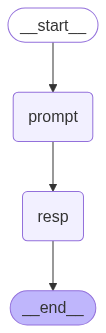

In [9]:
from IPython.display import Image, display
from io import BytesIO

# Get image bytes directly from your graph generator
image_bytes = app.get_graph().draw_mermaid_png()

# Display the image without saving
display(Image(data=image_bytes))


In [10]:
## run agent
state = {"question" : "" ,"doc_text":"", "answer" : ""}
result = app.invoke(state)
print(result["answer"])

🔹 Total chunks: 207
✅ Vector store created.


/tmp/ipykernel_972563/1938023155.py:13: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(query)


📄 Top 3 Relevant Chunks:

Chunk 1:
<<HEADING level=3>>5.4.1 General<<HEADING_END>>
<<PARAGRAPH>>A welding procedure shall be reestablished as a new welding procedure specification and shall be completely
requalified when any of the essential variables listed in 5.4.2 are changed. Changes other than those given in 5.4.2
may be made in the procedure without the need for requalification, provided the welding procedure specification is
revised to show the changes.<<PARAGRAPH_END>>

Chunk 2:
| 
<<PARAGRAPH>>A repair welder who has successfully completed the qualification test described in 10.4.3 shall be qualified within the
limits of the essential variables described below. If any of the following essential variables are changed, the repair
welder using a repair procedure shall be requalified:<<PARAGRAPH_END>>
<<PARAGRAPH>>a) any change from one repair type to another, except when changing from a full thickness repair to any partial
thickness repair;<<PARAGRAPH_END>>

Chunk 3:
the essentia